In [1]:
import torch
import pandas as pd
import numpy as np
import os
from models import model_init
from data_provider.data_factory import Data_Provider
import matplotlib.pyplot as plt
from utils.task import ahead_task_parser
from utils.tools import dotdict
import yaml, json

In [2]:
model = 'iTransformer'
data = 'solar'
ahead = 'day'
version = 'latest'
ckpt_base = './checkpoints'

ckpt_id = f'_{model}_{data}_{ahead}_ahead'

if version == 'latest':
    # find all the path that end with the ckpt_id
    ckpt_paths = [os.path.join(ckpt_base, i) for i in os.listdir(ckpt_base) if i.endswith(ckpt_id)]
    # the path is in format of yyyy-mm-dd{ckpt_id}, now find the latest one
    ckpt_paths.sort()
    ckpt_path = ckpt_paths[-1]
else:
    ckpt_path = version + ckpt_id

config = dotdict(json.load(open(os.path.join(ckpt_path, 'args.json'))))
config.model_config = dotdict(config.model_config)
config.data_config = dotdict(config.data_config)

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 1

In [3]:
model_TST = model_init(config.model, config.model_config, config).to(config.device)
# load the model
model_TST.load_state_dict(torch.load(os.path.join(ckpt_path, 'checkpoint.pth'))) 
model_TST.eval()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=168, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection): Linear(in_features=128, out_features=128, bias=True)
          (value_projection): Linear(in_features=128, out_features=128, bias=True)
          (out_projection): Linear(in_features=128, out_features=128, bias=True)
        )
        (conv1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwis

In [4]:
model = 'TGTSF'
data = 'solar'
ahead = 'day'
version = 'latest'#'04-16-0316'#'latest'
ckpt_base = './checkpoints'

ckpt_id = f'_{model}_{data}_{ahead}_ahead'

if version == 'latest':
    # find all the path that end with the ckpt_id
    ckpt_paths = [os.path.join(ckpt_base, i) for i in os.listdir(ckpt_base) if i.endswith(ckpt_id)]
    # the path is in format of yyyy-mm-dd{ckpt_id}, now find the latest one
    ckpt_paths.sort()
    ckpt_path = ckpt_paths[-1]
else:
    ckpt_path = version + ckpt_id
    ckpt_path = os.path.join(ckpt_base, ckpt_path)

config = dotdict(json.load(open(os.path.join(ckpt_path, 'args.json'))))
config.model_config = dotdict(config.model_config)
config.data_config = dotdict(config.data_config)

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 1
print(ckpt_path)

./checkpoints/04-16-0457_TGTSF_solar_day_ahead


In [5]:
model_TGTSF = model_init(config.model, config.model_config, config).to(config.device)
# load the model
model_TGTSF.load_state_dict(torch.load(os.path.join(ckpt_path, 'checkpoint.pth')))
model_TGTSF.eval()

Model(
  (TS_encoder): TS_encoder(
    (attentions): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (input_encoder): Linear(in_features=16, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.3, inplace=False)
  )
  (text_encoder): text_enco

In [6]:
id_data = Data_Provider(config)
fullsets = id_data.get_test('set')
print(fullsets.keys())

[ info ] Successfully load the dynamic data embedding from fast_general_formal_embeddings_????.pkl


Loading test datasets: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])


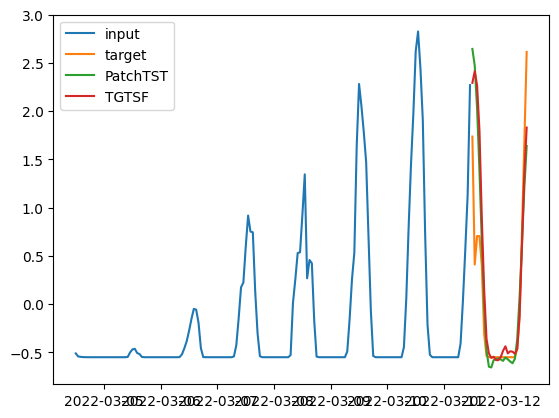

In [7]:
sample_num = 1500
batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets['314106'][sample_num]

batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

output_TST = model_TST(x=batch_x)
output_TST = output_TST[:, -config.output_len:, :]

output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
output_TGTSF = output_TGTSF[:, -config.output_len:, :]



indate = [str(i) for i in timestamp_x]
outdate = [str(i) for i in timestamp_y]
# convert the yyyymmddHHMMSS to datetime
indate = pd.to_datetime(indate, format='%Y%m%d%H%M%S')
outdate = pd.to_datetime(outdate, format='%Y%m%d%H%M%S')
# reformat the indate as datetime
# plot the result
# enable inline plotting
%matplotlib inline
plt.plot(indate, batch_x.cpu().detach().numpy().squeeze(), label='input')
plt.plot(outdate, batch_y.cpu().detach().numpy().squeeze(), label='target')
plt.plot(outdate, output_TST.cpu().detach().numpy().squeeze(), label='PatchTST')
plt.plot(outdate, output_TGTSF.cpu().detach().numpy().squeeze(), label='TGTSF')
plt.legend()

In [51]:
selectset = '314106'
losslist = {}
for sample_num in range(0, len(fullsets[selectset]), 24):
    batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets['314106'][sample_num]

    batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
    batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
    batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
    hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

    output_TST = model_TST(x=batch_x)
    output_TST = output_TST[:, -config.output_len:, :]

    output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
    output_TGTSF = output_TGTSF[:, -config.output_len:, :]

    # calculate the loss
    loss_TST = torch.nn.MSELoss()(output_TST, batch_y)
    loss_TGTSF = torch.nn.MSELoss()(output_TGTSF, batch_y)
    loss_mutual = torch.nn.MSELoss()(output_TST, output_TGTSF)
    losslist[sample_num] = {
        'loss_TST': loss_TST.item(),
        'loss_TGTSF': loss_TGTSF.item(),
        'loss_mutual': loss_mutual.item(),
    }


In [52]:
# convert to pandas df
lossdf = pd.DataFrame(losslist).T
lossdf

,loss_TST,loss_TGTSF,loss_mutual
0,0.000004,0.002498,0.002330
24,0.000004,0.002906,0.002728
48,0.000004,0.002580,0.002414
72,0.000004,0.002479,0.002316
96,0.000004,0.002634,0.002468
...,...,...,...
27408,0.392889,0.133649,0.135464
27432,0.191818,0.035795,0.106640
27456,0.096853,0.023567,0.087837
27480,0.073532,0.035434,0.043072


In [53]:
# sort the df by loss_TST
lossdf = lossdf.sort_values(by='loss_mutual', ascending=False)
lossdf

,loss_TST,loss_TGTSF,loss_mutual
2256,1.678635,0.003029,1.608992
3144,0.700148,0.199354,1.406990
11232,0.930015,0.027264,1.206781
12216,1.492104,0.046542,1.104350
10632,1.072038,0.047870,1.002726
...,...,...,...
25536,0.040417,0.040122,0.001297
9336,0.002990,0.002796,0.001249
7344,0.003563,0.004727,0.001034
1152,0.002674,0.005214,0.001013


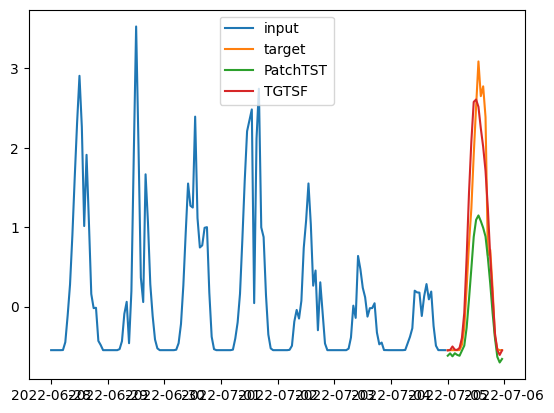

In [64]:
sample_num = 4272#2256#20136
batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets['314106'][sample_num]

batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

output_TST = model_TST(x=batch_x)
output_TST = output_TST[:, -config.output_len:, :]

output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
output_TGTSF = output_TGTSF[:, -config.output_len:, :]



indate = [str(i) for i in timestamp_x]
outdate = [str(i) for i in timestamp_y]
# convert the yyyymmddHHMMSS to datetime
indate = pd.to_datetime(indate, format='%Y%m%d%H%M%S')
outdate = pd.to_datetime(outdate, format='%Y%m%d%H%M%S')
# reformat the indate as datetime
# plot the result
# enable inline plotting
%matplotlib inline
plt.plot(indate, batch_x.cpu().detach().numpy().squeeze(), label='input')
plt.plot(outdate, batch_y.cpu().detach().numpy().squeeze(), label='target')
plt.plot(outdate, output_TST.cpu().detach().numpy().squeeze(), label='PatchTST')
plt.plot(outdate, output_TGTSF.cpu().detach().numpy().squeeze(), label='TGTSF')
plt.legend()